In [5]:
#!pip install --upgrade pip

In [6]:
#!pip install librosa

In [7]:
#!pip install pydub

In [8]:
#!pip install ffmpeg

In [5]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from pydub import AudioSegment
import os
import pandas as pd
import tensorflow
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sn

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


Se guardan las rutas de los 2 tipos de audio

In [6]:
normal = '/home/ec2-user/SageMaker/ACM/audio normal/'
anomalo = '/home/ec2-user/SageMaker/ACM/audio contaminado/'

Funcion para obtener el nombre de los archivos de audio

In [7]:
def contenido_audios():
    a = os.listdir(normal)
    b = os.listdir(anomalo)
    return a,b

In [8]:
c1,c2 = contenido_audios()

Funcion para obtener los metadatos de audio (File name, Channels, Sample width, Frame rate/Sample rate, Frame width, Length, Intensity) y guardarlos como dataframe

contenido: Nombre de los audios, tipo_audio: Etiqueta a la que pertenece (normal, anomalo)

In [9]:
def metadatos(contenido,tipo_audio):
    df = pd.DataFrame()
    df['file name'] = None
    df['Channels'] = None
    df['Sample width'] = None
    df['Frame rate (sample rate)'] = None
    df['Frame width'] = None
    df['Length (seg)'] = None
    df['Frame count'] = None
    df['Intensity'] = None
    for i in range(len(contenido)):
        audio_segment = AudioSegment.from_file(tipo_audio+str(contenido[i]))
        df.loc[i] = [contenido[i],audio_segment.channels,audio_segment.sample_width,audio_segment.frame_rate,
                        audio_segment.frame_width,len(audio_segment)/1000,audio_segment.frame_count(),
                        audio_segment.dBFS]

    return df

Se obtienen los metadatos del audio normal y se le agrega al dataframe una columna llamada 'etiqueta' con 'normal'

In [10]:
metadatos_audio_normal = metadatos(c1,normal)
metadatos_audio_normal = metadatos_audio_normal.assign(etiqueta='normal')

Se obtienen los metadatos del audio contaminado y se le agrega al dataframe una columna llamada 'etiqueta' con 'anomalo'

In [11]:
metadatos_audio_anomalo = metadatos(c2,anomalo)
metadatos_audio_anomalo = metadatos_audio_anomalo.assign(etiqueta='anomalo')

Se juntan los 2 dataframes

In [12]:
metadatos = pd.concat([metadatos_audio_normal, metadatos_audio_anomalo], axis=0, ignore_index=True)

Preprocesamiento: Se escoge el Frame_size, HOP_LENGTH, WINDOW

Ademas se deja el sample rate fijo

In [13]:
Frame_size = 1024
HOP_LENGTH = 512 
WINDOW = 'hann'
SR = 44100

Funcion donde se carga el audio, se obtiene la stft y el espectrograma, y se calcula la media de cada fila del espectrograma, luego se guarda en un dataframe

In [14]:
def feature(contenido,tipo_audio):
    df = pd.DataFrame()
    df['file name'] = None
    df['y'] = None
    df['stft'] = None
    df['Espectrograma'] = None
    df['Espectrograma scaled'] = None
    for i in range(len(contenido)):
        y, sr = librosa.load(tipo_audio+str(contenido[i]),sr=SR,mono=True)
        stft = librosa.stft(y,n_fft=Frame_size,hop_length=HOP_LENGTH,window=WINDOW)
        espectrograma = np.abs(stft)**2
        espectrograma_scaled = np.mean(espectrograma.T,axis=0)
        df.loc[i] = [contenido[i],y,stft,espectrograma,espectrograma_scaled]
    return df

Funcion para escuchar un archivo de audio

In [15]:
def escuchar_audio(y,sr):
    audio = Audio(data=y, rate=sr)
    return audio

Funcion para graficar la forma de onda (waveform)

In [16]:
def plot_waveform(y,sr):
    plt.figure(figsize = (15, 10))
    librosa.display.waveshow(y=y, sr=sr)
    plt.xlabel('Tiempo', fontsize = 15)
    plt.ylabel('Amplitud', fontsize = 15)
    plt.show()

Funcion para graficar el espectrograma (spectrogram) en escala logaritmica

In [17]:
def plot_spectrogram(spectrogram,hop_length,sr):
    plt.figure(figsize = (15, 10))
    D = librosa.power_to_db(spectrogram)
    librosa.display.specshow(D,sr=sr,hop_length=hop_length,y_axis='log',x_axis='time')
    plt.colorbar(format='%+2.f')
    plt.show()

Utilizamos la funcion feature en el audio normal y al dataframe le agregamos la columna llamada 'etiqueta' con 0

In [18]:
df_audio_normal = feature(c1,normal)
df_audio_normal = df_audio_normal.assign(etiqueta=0)

Utilizamos la funcion feature en el audio anomalo y al dataframe le agregamos la columna llamada 'etiqueta' con 1

In [19]:
df_audio_anomalo = feature(c2,anomalo)
df_audio_anomalo = df_audio_anomalo.assign(etiqueta=1)

Juntamos los 2 dataframes

In [88]:
df_audios = pd.concat([df_audio_normal, df_audio_anomalo], axis=0,ignore_index=True)

In [89]:
X=np.array(df_audios['Espectrograma scaled'].tolist())
y=np.array(df_audios['etiqueta'].tolist())

In [90]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=1,stratify=y)

Utilizamos gaussian naive bayes

In [65]:
gnb = GaussianNB(var_smoothing=1e-19)
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

Calculamos la exactitud (accuracy)

In [66]:
accuracy = accuracy_score(y_test,y_pred)
print("Accuracy:",accuracy)

Accuracy: 0.98


Obtenemos la matriz de confusion

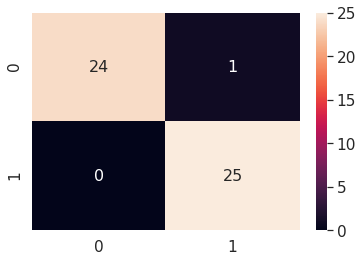

In [67]:
matrix = confusion_matrix(y_test, y_pred)
matriz = pd.DataFrame(matrix,range(2),range(2))
#plt.figure(figsize=(10,10))
sn.set(font_scale=1.4) # for label size
sn.heatmap(matriz, annot=True, annot_kws={"size": 16}) # font size
plt.savefig('matriz de confusion.png')

plt.show()